# **Automatic Prediction of MOSFET Threshold Voltage using Machine Learning**

This project implements the approach described in the research paper  
**“Automatic Prediction of MOSFETs Threshold Voltage by Machine Learning Algorithms” (EDTM 2023)**.

The goal is to automatically predict the **threshold voltage** $V_{\text{th}}$ of different MOSFET devices using **machine learning regression models**.  
Traditional $V_{\text{th}}$ extraction methods such as the **Constant Current (CC)**, **Second Derivative**, or **Y–Function** methods can be time-consuming and dependent on researcher interpretation.  
This project replaces that manual process with a **data-driven, objective ML approach**.

----

### **Project Overview**
- **Dataset:** MESD (MOSFET Electrical Simulation Dataset)  
- **Input Features:** Drain current–gate voltage characteristics, i.e., $I_{\text{D}}$–$V_{\text{G}}$ curves  
- **Output Target:** Threshold voltage $V_{\text{th}}$ or its normalized ratio $R_{\text{th}}$  
- **ML Models Used:**  
  - $k$-Nearest Neighbors Regression (kNN)  
  - Decision Tree Regression  
- **Evaluation Metrics:**  
  - Root Mean Square Error (RMSE)  
  - Mean Absolute Error (MAE)  
  - Coefficient of Determination $R^2$

----

### **Objective**
To build a machine learning model that can accurately predict the **threshold voltage** $V_{\text{th}}$ of various MOSFET devices from their $I_{\text{D}}$–$V_{\text{G}}$ characteristics, thereby eliminating subjectivity and improving consistency in device analysis.


In [15]:
import json
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import os
import glob

In [16]:
!git clone https://github.com/SJTU-YONGFU-RESEARCH-GRP/MESD-MOSFET-Electrical-Simulation-Dataset.git

# !ls MESD-MOSFET-Electrical-Simulation-Dataset/MESD


fatal: destination path 'MESD-MOSFET-Electrical-Simulation-Dataset' already exists and is not an empty directory.


## **Load the Dataset**

This section clones the **MESD (MOSFET Electrical Simulation Dataset)** from GitHub, which contains electrical simulation data for various MOSFET devices.

The dataset includes:
- Multiple device types (nMOS, pMOS, FinFET, etc.)
- Different PDKs (Process Design Kits)
- I–V characteristics, i.e., $V_{\text{GS}}$–$I_{\text{D}}$ curves
- Device metadata (temperature, dimensions, etc.)


In [17]:
def load_mesd_data():
  data_folder_path = 'MESD-MOSFET-Electrical-Simulation-Dataset/MESD'
  json_files = glob.glob(os.path.join(data_folder_path, "*.json"))
  json_files.sort()
  all_data = []
  for file_path in json_files:
    file_name = os.path.basename(file_path)
    if file_name == "N180A-pmos1.json":
      print(f"Skipping: {file_name}")
      continue
    with open(file_path, 'r') as f:
      data = json.load(f)
      all_data.append(data)
  return all_data

# Load the dataset
mesd_data = load_mesd_data()
print(f"Loaded {len(mesd_data)} JSON files")

Skipping: N180A-pmos1.json
Loaded 43 JSON files


## **Threshold Voltage Extraction Methods**

This function implements three different methods to extract the threshold voltage ($V_{th}$) from I-V curves:

### Method 1: Second Derivative (Default)
Finds the peak of the second derivative of $\log_{10}(I_D)$ with respect to $V_{GS}$:

$$\frac{d^2(\log_{10} I_D)}{dV_{GS}^2}$$

### Method 2: Constant Current
Finds $V_{GS}$ at a predefined current level (e.g., $10^{-7}$ A)

### Method 3: Y-Function
Extrapolates the linear region of the Y-function to find the x-intercept

In [18]:
def extract_threshold_voltage(vgs, ids, method='2nd_derivative'):
  if method == '2nd_derivative':
      # Calculate 2nd derivative of log(Ids) w.r.t Vgs
      log_ids = np.log10(np.abs(ids) + 1e-15)
      first_deriv = np.gradient(log_ids, vgs)
      second_deriv = np.gradient(first_deriv, vgs)

      # Find peak of 2nd derivative
      peak_idx = np.argmax(second_deriv)
      return vgs[peak_idx]

  elif method == 'constant_current':
      # Find Vgs at predefined current level
      target_current = 1e-7
      idx = np.argmin(np.abs(ids - target_current))
      return vgs[idx]

  elif method == 'y_function':
      y_func = ids / np.sqrt(np.abs(ids) + 1e-15)
      linear_region = y_func[len(y_func)//2:]
      vgs_linear = vgs[len(vgs)//2:]

      coeffs = np.polyfit(vgs_linear, linear_region, 1)
      vth = -coeffs[1] / coeffs[0]
      return vth

## **Calculate Threshold Ratio ($R_{\text{th}}$)**

This function normalizes the threshold voltage to a ratio between 0 and 1 based on the $V_{\text{GS}}$ range.

**Formula:**

$$
R_{\text{th}} = \frac{V_{\text{th}} - V_{G,\text{min}}}{V_{G,\text{max}} - V_{G,\text{min}}}
$$

**Purpose:**
- Normalizes $V_{\text{th}}$ to a dimensionless value (0 to 1)
- Makes the target variable independent of the specific voltage range
- Improves ML model generalization across different device types
- Acts as the target variable (label) for supervised learning


In [19]:
def calculate_threshold_ratio(vgs, vth):
  vg_min, vg_max = min(vgs), max(vgs)
  rth = (vth - vg_min) / (vg_max - vg_min)
  return rth

## **Preprocess MESD Data for ML Training**

This function processes raw MESD dataset records into a structured format suitable for machine learning.

**Key Steps:**
1. **Extract device metadata** (Type, PDK) from each file
2. **Extract $V_{\text{th}}$** using the specified method (2nd derivative by default)
3. **Normalize I–V curves**:
   - $V_{\text{GS}}$ normalization: $\frac{V_{\text{GS}} - V_{G,\text{min}}}{V_{G,\text{max}} - V_{G,\text{min}}}$
   - $I_{\text{DS}}$ normalization: $\frac{I_{\text{DS}} - I_{\text{DS,min}}}{I_{\text{DS,max}} - I_{\text{DS,min}}}$
4. **Calculate threshold ratio ($R_{\text{th}}$)**
5. **Create feature vectors** from normalized $I_{\text{DS}}$ values

**Output:** List of dictionaries containing:
- `features`: Normalized I–V curve (array)
- `rth`: Threshold ratio target value ($R_{\text{th}}$)
- `metadata`: Device information
- `vgs_range`: $(V_{G,\text{min}}, V_{G,\text{max}})$ for inverse transformation


In [20]:
def preprocess_mesd_data(mesd_data, extraction_method='2nd_derivative'):
  VG_NORMALIZED_AXIS_50 = np.linspace(0, 1, 50)
  MIN_ON_CURRENT = 1e-7


  processed_data = []

  for device_data in mesd_data:
      device_type = device_data['Type']
      pdk = device_data['PDK']

      for record in device_data['Records']:

          vgs = np.array(record['Vgs'])
          ids = np.array(record['Ids'])

          # Filter out the data whose Corner is not "tt" (Typical-Typical)
          if (record.get('Corner') != "tt"):
            continue

          try:

              log_ids = np.log10(np.abs(ids)+ 1e-15)
              # Normalize VG and interpolate Ids
              vgs_norm = (vgs - vgs.min()) / (vgs.max() - vgs.min())
              sort_indices = np.argsort(vgs_norm)
              vgs_norm_sorted = vgs_norm[sort_indices]
              log_ids_sorted = log_ids[sort_indices]
              vgs_resampled = np.interp(VG_NORMALIZED_AXIS_50, vgs_norm_sorted, vgs[sort_indices])
              ids_resampled = np.interp(VG_NORMALIZED_AXIS_50, vgs_norm_sorted, ids[sort_indices])

              vth = extract_threshold_voltage(vgs_resampled, ids_resampled, extraction_method)
              rth = calculate_threshold_ratio(vgs_resampled, vth)

              log_ids_resampled = np.interp(VG_NORMALIZED_AXIS_50, vgs_norm_sorted, log_ids_sorted)

              min_log_id = log_ids_resampled.min()
              max_log_id = log_ids_resampled.max()

              # Filtering out flat lines
              if np.isclose(max_log_id, min_log_id):
                  continue

              # Create feature vector with normalized Ids values
              ids_norm = (log_ids_resampled - min_log_id) / (max_log_id - min_log_id)
              features = ids_norm

              processed_data.append({
                  'features': features,
                  'rth': rth,
                  'vth' : vth,
                  'device_type': device_type,
                  'pdk': pdk,
                  'vgs_range': (vgs.min(), vgs.max()),
                  'metadata': {
                      'temp': record.get('Temp', 25),
                      'vds': record.get('Vds', 0),
                      'w': record.get('W', 0),
                      'l': record.get('L', 0),
                      'nfin': record.get('Nfin', 1)
                  }
              })
          except Exception as e:
              print(f"Error processing record: {e}")
              continue

  return processed_data

processed_data = preprocess_mesd_data(mesd_data, extraction_method='2nd_derivative')

## **Create Feature Matrix with Consistent Dimensions**

This function prepares the processed data for ML by creating consistent-length feature vectors.

**Process:**
- Determines maximum feature length across all samples
- Pads shorter sequences with zeros to match max_length
- Truncates longer sequences to max_length
- Returns numpy arrays for X (features) and y (targets)


In [21]:
def create_feature_matrix(processed_data):
  X = []
  y = []
  metadata = []

  for data in processed_data:
      features = data['features']
      X.append(features)
      y.append(data['rth'])
      metadata.append(data['metadata'])

  return np.array(X), np.array(y), metadata

# Process the data
X, y, metadata = create_feature_matrix(processed_data)

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")


Feature matrix shape: (102800, 50)
Target vector shape: (102800,)


In [22]:
def train_by_device(processed_data, test_size=0.3, random_state=42):


    device_data_groups = {}
    for data in processed_data:
        dtype = data['device_type']
        if dtype not in device_data_groups:
            device_data_groups[dtype] = []
        device_data_groups[dtype].append(data)

    results = {}

    for dtype, dtype_data in device_data_groups.items():
        print(f"\nProcessing Device Type: {dtype}")

        X_dtype, y_dtype,_ = create_feature_matrix(dtype_data)
        print(f"Data shape for {dtype}: X={X_dtype.shape}, y={y_dtype.shape}")

        X_train, X_test, y_train, y_test = train_test_split(
            X_dtype, y_dtype, test_size=test_size, random_state=random_state
        )

        models_to_train = {
            'kNN': KNeighborsRegressor(n_neighbors=5),
            'Decision Tree': DecisionTreeRegressor(max_depth=10, random_state=random_state)
        }

        device_results = {}

        for name, model in models_to_train.items():
            print(f"\nTraining {name} for {dtype}")

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            device_results[name] = {
                'model': model,
                'rmse': rmse,
                'mae': mae,
                'r2': r2,
                'predictions': y_pred,
                'actual': y_test
            }

            print(f"{name} Results for {dtype}:")
            print(f"  RMSE: {rmse:.4f}")
            print(f"  MAE:  {mae:.4f}")
            print(f"  R²:   {r2:.4f}")

        results[dtype] = device_results

    return results
results = train_by_device(processed_data, test_size=0.3, random_state=42)


Processing Device Type: NMOS
Data shape for NMOS: X=(51900, 50), y=(51900,)

Training kNN for NMOS
kNN Results for NMOS:
  RMSE: 0.0214
  MAE:  0.0039
  R²:   0.9669

Training Decision Tree for NMOS
Decision Tree Results for NMOS:
  RMSE: 0.0364
  MAE:  0.0136
  R²:   0.9040

Processing Device Type: PMOS
Data shape for PMOS: X=(50900, 50), y=(50900,)

Training kNN for PMOS
kNN Results for PMOS:
  RMSE: 0.0207
  MAE:  0.0043
  R²:   0.9675

Training Decision Tree for PMOS
Decision Tree Results for PMOS:
  RMSE: 0.0339
  MAE:  0.0133
  R²:   0.9126


Plotting predictions for: NMOS
Plotting predictions for: PMOS


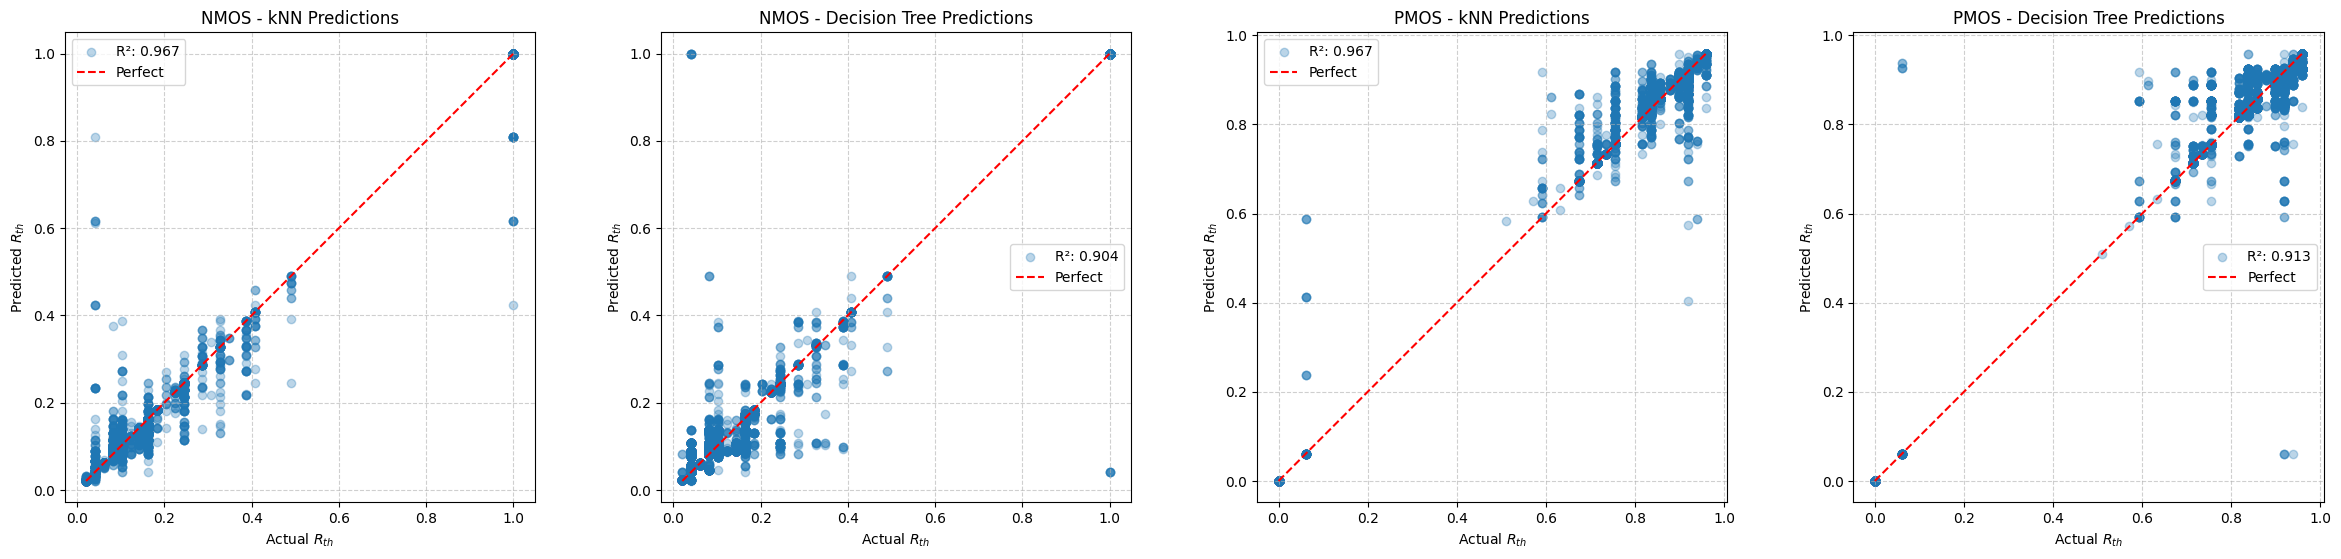

In [23]:
def plot_device_predictions(results):

    num_device_types = len(results)


    num_cols = 2
    num_rows = (num_device_types + num_cols - 1) // num_cols
    model_names = ['kNN', 'Decision Tree']

    fig, axs = plt.subplots(num_rows, num_cols * len(model_names),
                            figsize=(6 * len(model_names) * num_cols, 5.5 * num_rows),
                            squeeze=False)

    device_idx = 0
    for dtype, device_res in results.items():
        row_idx = device_idx // num_cols
        col_offset = (device_idx % num_cols) * len(model_names)

        print(f"Plotting predictions for: {dtype}")

        for model_idx, name in enumerate(model_names):
            if name in device_res:
                res = device_res[name]
                y_test = res['actual']
                y_pred = res['predictions']
                current_ax = axs[row_idx, col_offset + model_idx]

                # Scatter plot
                current_ax.scatter(y_test, y_pred, alpha=0.3, label=f'R²: {res["r2"]:.3f}')
                # Perfect prediction line
                min_val = min(np.min(y_test), np.min(y_pred))
                max_val = max(np.max(y_test), np.max(y_pred))
                current_ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect')

                current_ax.set_title(f"{dtype} - {name} Predictions")
                current_ax.set_xlabel("Actual $R_{th}$")
                current_ax.set_ylabel("Predicted $R_{th}$")
                current_ax.legend()
                current_ax.grid(True, ls='--', alpha=0.6)
                current_ax.set_aspect('equal', adjustable='box')
            else:
                 axs[row_idx, col_offset + model_idx].set_title(f"{dtype} - {name} (No Data)")
                 axs[row_idx, col_offset + model_idx].axis('off')

        device_idx += 1

    total_subplots = num_rows * num_cols * len(model_names)
    plotted_subplots = num_device_types * len(model_names)
    for i in range(plotted_subplots, total_subplots):
       row = i // (num_cols*len(model_names))
       col = i % (num_cols*len(model_names))
       if row < axs.shape[0] and col < axs.shape[1]:
           axs[row, col].axis('off')

    plt.tight_layout()
    plt.show()
plot_device_predictions(results)

In [24]:
def predict_threshold_voltage(models, device_type, vgs_range, ids_normalized, model_type='kNN'):
    if device_type in models and model_type in models[device_type]:
      model = models[device_type][model_type]['model']
    rth_pred = model.predict(ids_normalized.reshape(1, -1))[0]

    # Convert back to actual threshold voltage
    vg_min, vg_max = vgs_range
    vth_pred = rth_pred * (vg_max - vg_min) + vg_min

    return vth_pred, rth_pred

In [25]:
print(results)

{'NMOS': {'kNN': {'model': KNeighborsRegressor(), 'rmse': np.float64(0.021390060472790226), 'mae': 0.003905731849579911, 'r2': 0.9668863974117066, 'predictions': array([0.08979592, 0.10204082, 0.08163265, ..., 0.16326531, 0.10204082,
       0.08163265]), 'actual': array([0.08163265, 0.10204082, 0.08163265, ..., 0.16326531, 0.10204082,
       0.08163265])}, 'Decision Tree': {'model': DecisionTreeRegressor(max_depth=10, random_state=42), 'rmse': np.float64(0.03642419776681104), 'mae': 0.013582728428994698, 'r2': 0.9039798459944397, 'predictions': array([0.08869227, 0.10204082, 0.0851819 , ..., 0.15225866, 0.08883671,
       0.08116419]), 'actual': array([0.08163265, 0.10204082, 0.08163265, ..., 0.16326531, 0.10204082,
       0.08163265])}}, 'PMOS': {'kNN': {'model': KNeighborsRegressor(), 'rmse': np.float64(0.020667319951464303), 'mae': 0.0043475936543576335, 'r2': 0.9674559419652112, 'predictions': array([0.93877551, 0.91836735, 0.95918367, ..., 0.65714286, 0.75510204,
       0.91836735

In [27]:
import random
VTH_TOLERANCE = 1e-3
MODEL_TYPE = 'kNN'

# 100 random samples
validation_set = random.sample(processed_data, k=100)

match_count = 0
valid_samples = 0

print(f"Running validation on 100 random samples using {MODEL_TYPE}...")

for sample_device in validation_set:
    # Extract the device type (NMOS/PMOS) to select the correct model.
    dtype = sample_device['device_type']

    vth_pred, rth_pred = predict_threshold_voltage(
        results,
        dtype,
        sample_device['vgs_range'],
        sample_device['features'],
        model_type=MODEL_TYPE
    )

    vth_true = sample_device.get('vth')
    if vth_pred is not None and vth_true is not None:
        valid_samples += 1
        if np.isclose(vth_pred, vth_true, atol=VTH_TOLERANCE):
            match_count += 1

print(f"Number of accurate predictions within {VTH_TOLERANCE} V: {match_count}/{valid_samples}")

Running validation on 100 random samples using kNN...
Number of accurate predictions within 0.001 V: 95/100
